# EDA

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy import signal

In [7]:
raw_data = "../raw/train.csv"
sub_data = "../raw/sample_submission.csv"
test_data = "../raw/test/{}.csv" 
proc_data = "../processed/{}"

In [3]:
df = pd.read_csv(sub_data, header=0).set_index("seg_id")
df["time_to_failure"] = 2
df.to_csv("qqq.csv")

In [54]:
df = pd.read_csv(raw_data, header=0, nrows=5656574)
df.columns = ["x", "y"]

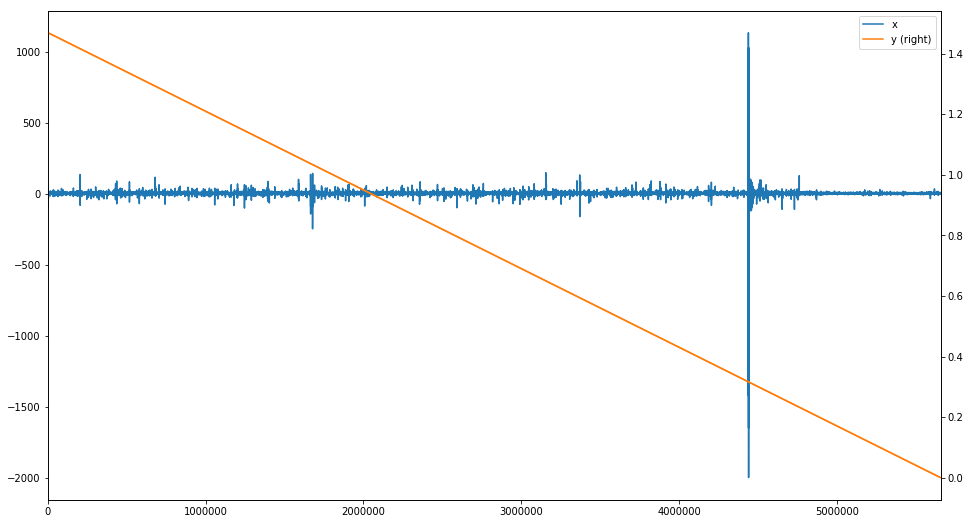

In [55]:
df.loc[::100,:].plot(figsize=(16,9), secondary_y=["y"])

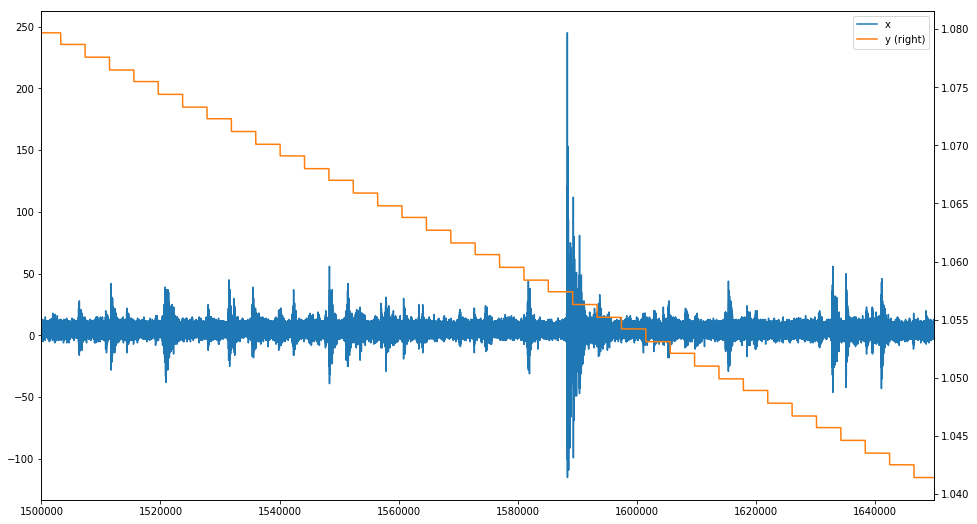

In [57]:
block = 150000
num = 10
df.loc[num * block: (num + 1) * block].plot(figsize=(16,9), secondary_y=["y"])

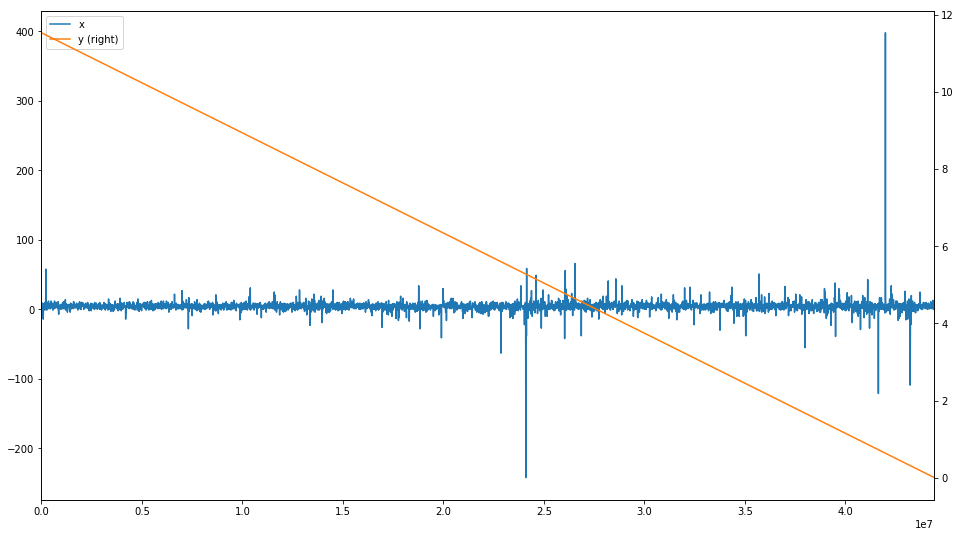

In [11]:
df = pd.read_csv(raw_data, skiprows=5656574, nrows=44429303)
df.columns = ["x", "y"]
df.loc[::10000,:].plot(figsize=(16,9), secondary_y=["y"])

In [38]:
summary = []
for name in tqdm_notebook(pd.read_csv(sub_data).seg_id):
    summary.append(pd.read_csv(test_data.format(name)).describe())

In [69]:
def yield_train_blocks(chunksize=150000):
    yield from pd.read_csv(
        raw_data, 
        names=["x", "y"], 
        dtype={"x": "int32", "y": "float32"}, 
        skiprows=1, 
        chunksize=chunksize
    )

In [70]:
def yield_sub_series():
    min_y = None
    blocks = []
    for block in yield_train_blocks():
        blocks.append(block)
        block_min_time = block.y.min()
        if min_y is None or block_min_time < min_y:
            min_y = block_min_time
            continue
        df = pd.concat(blocks, ignore_index=True)
        end_of_series = df.y.idxmin()
        blocks = [df.loc[end_of_series+1:]]
        min_y = blocks[0].y.min()
        yield df.loc[:end_of_series]
    yield pd.concat(blocks, ignore_index=True)

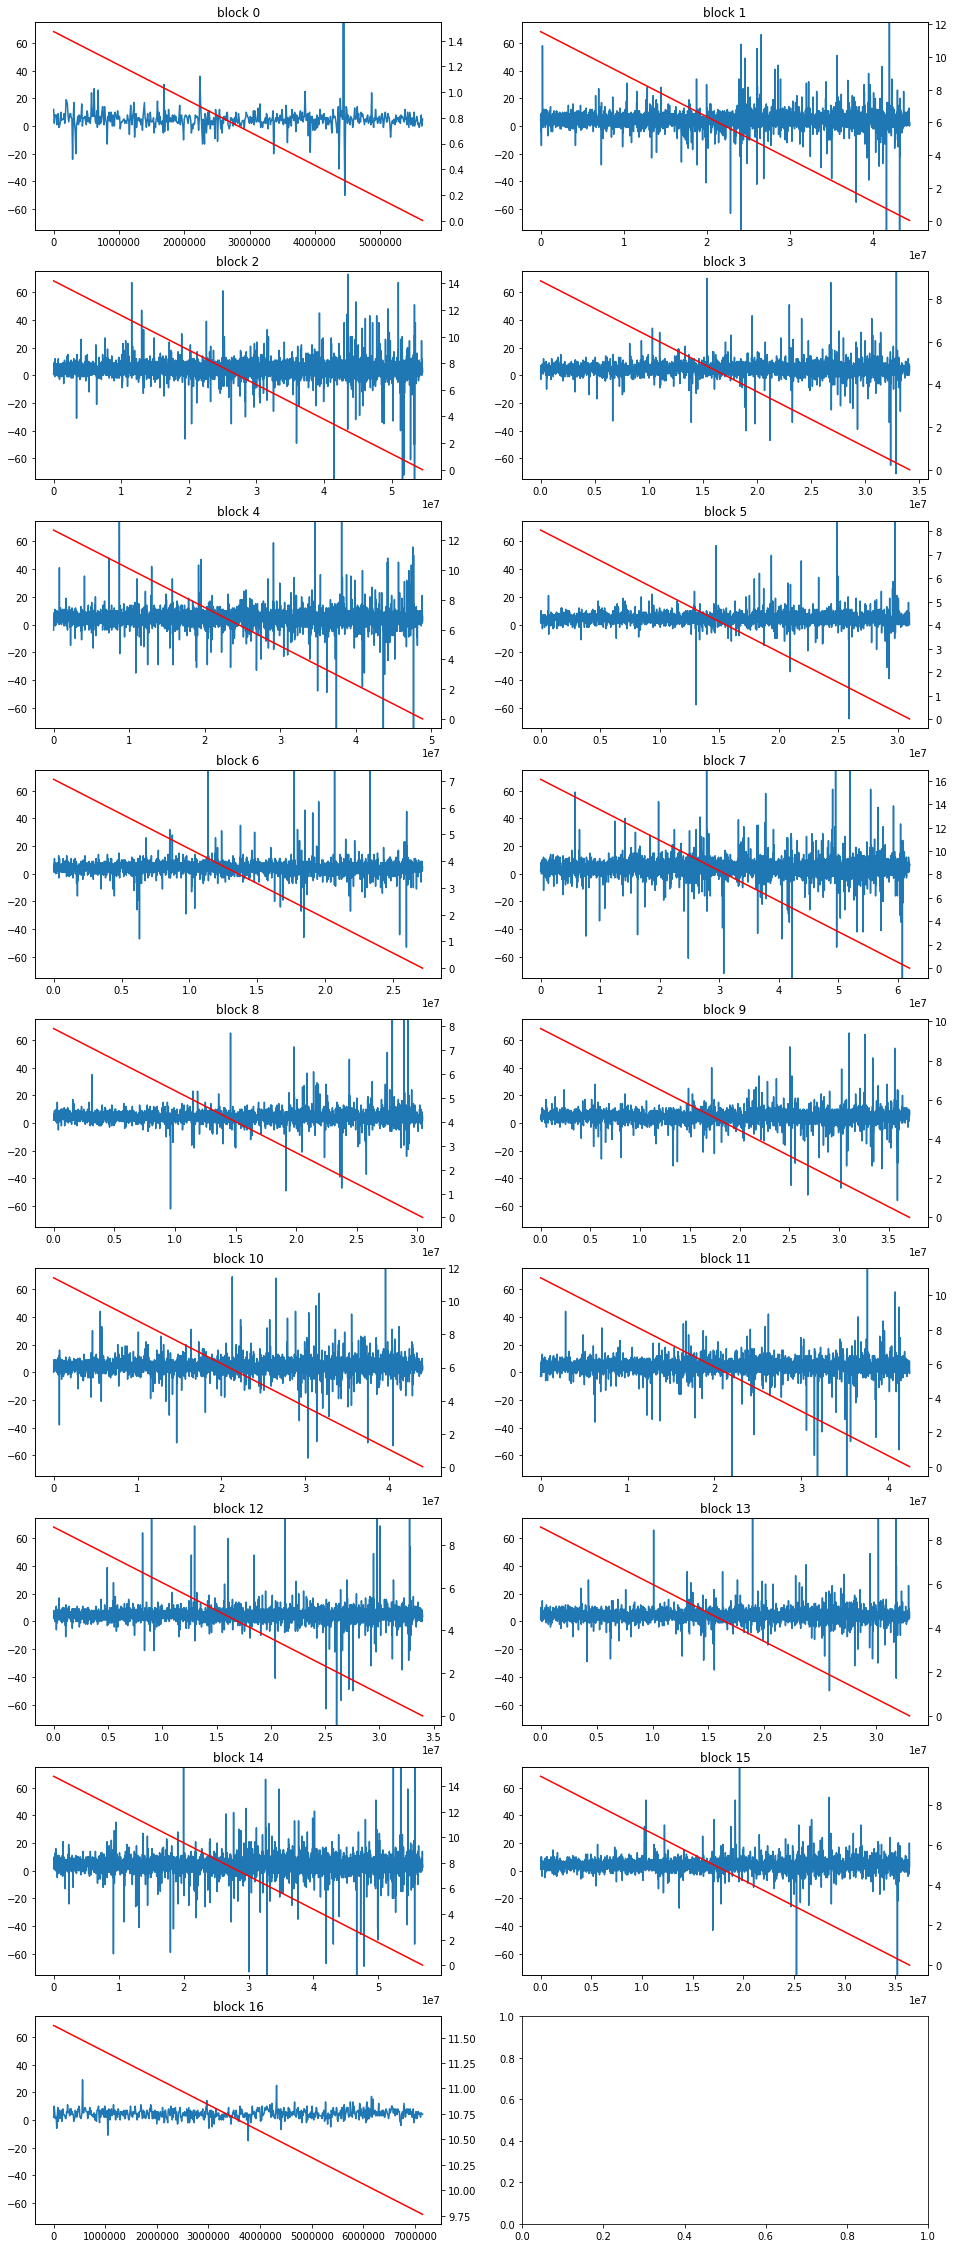

In [72]:
_, axs = plt.subplots(9, 2, figsize=(16, 9 * 9 / 2))
axs = axs.flatten()
for i, df in tqdm_notebook(enumerate(yield_sub_series())):
    axs[i].set_title(f"block {i}") 
    ax2 = axs[i].twinx()
    axs[i].set_ylim(-75, 75)
    step = len(df) // 5000
    axs[i].plot(df.x.loc[::step])   
    ax2.plot(df.y.loc[::step], color='r')   

# Анализ признаков

In [12]:
def yield_train_blocks(chunk_size=150000):
    dfs_gen = pd.read_csv(
        raw_data,
        names=["x", "y"],
        dtype={"x": "int32", "y": "float32"},
        skiprows=1,
        chunksize=chunk_size
    )
    for df in dfs_gen:
        time = df.y
        first_time = time.iloc[0]
        last_time = time.iloc[-1]
        if first_time < last_time:
            continue
        if len(df) == chunk_size:
            df.reset_index(drop=True, inplace=True)
            yield df.x, last_time

In [49]:
data = []
for df_x, y in tqdm_notebook(yield_train_blocks()):
    stds = df_x.rolling(375).std().dropna()
    half = len(stds) // 2
    x = stds.iloc[: half].median() / stds.iloc[-half:].median()
    data.append([x, y])

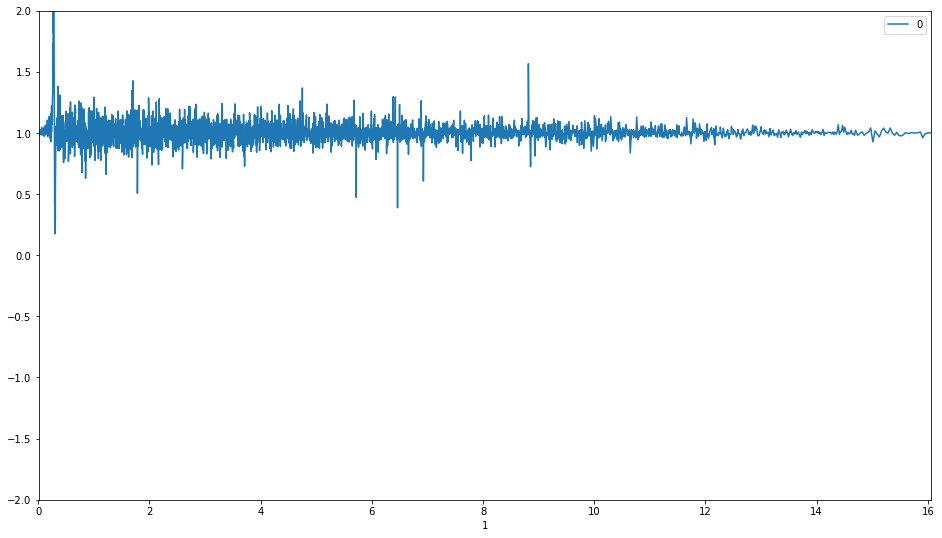

In [50]:
(pd.DataFrame(data).set_index(1).sort_index()).plot(figsize=(16,9), ylim=(-2, 2))

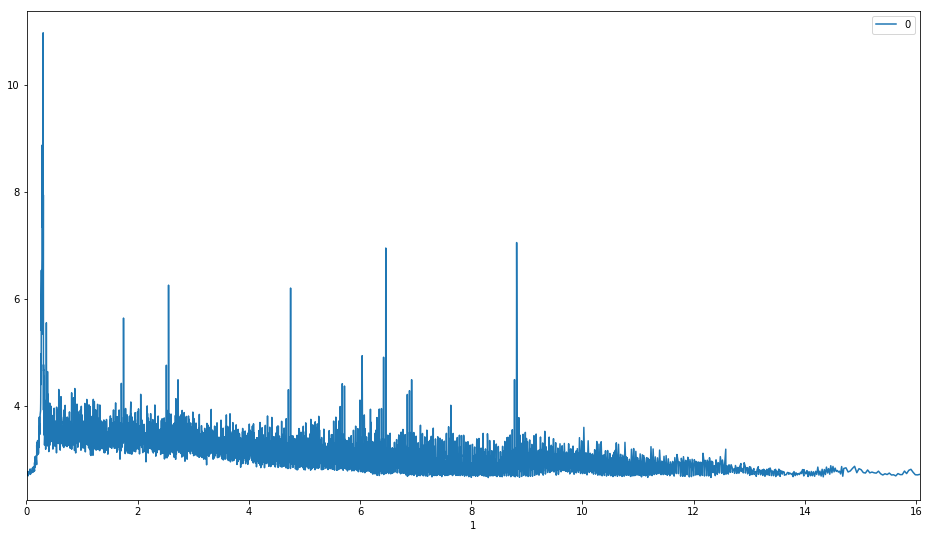

In [16]:
pd.DataFrame(data).set_index(1).sort_index().plot(figsize=(16,9))

# Анализ OOF предсказания

In [50]:
df = pd.read_pickle(proc_data.format("oof.pickle"))

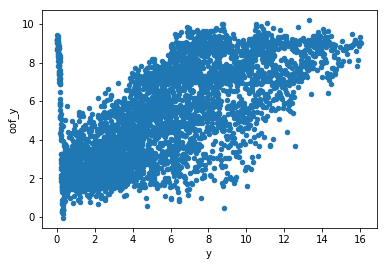

In [51]:
df.plot.scatter("y", "oof_y")

In [41]:

df["oof_y"] = (df["oof_y"] - df["y"]).abs()
rez = df.groupby(lambda x: int(df.y.loc[x] * 10) / 10).agg({"oof_y": ["mean"]})

In [49]:
df.oof_y.min()

-0.037026551253607036

In [42]:
rez.head()

,oof_y
,mean
0.0,8.670522
0.1,6.667437
0.2,1.884256
0.3,1.471129
0.4,1.940196


In [43]:
rez.tail()

,oof_y
,mean
15.6,6.674464
15.7,6.773595
15.8,7.452911
15.9,7.257620
16.0,6.880331


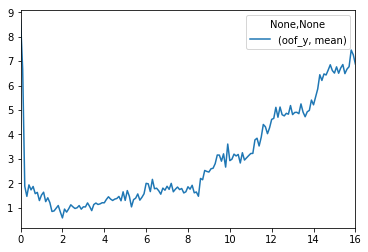

In [44]:
rez.plot()

# Важность признаков

In [10]:
df = pd.read_pickle(proc_data.format("importance.pickle"))
df

,1
0,
std_roll_med_375,55.515208
mean,9.763155
mean_abs_med,6.730676
std_roll_min_375,5.776307
mean_abs_min,4.279294
std,3.151433
std_roll_max_375,3.059149
skew,2.710539
kurt,2.549380


In [9]:
df.groupby(lambda x: x[:4]).sum().sort_values(1, ascending=False)

,1
std_,64.350665
mean,23.023158
std,3.151433
skew,2.710539
kurt,2.549380
max,2.182959
min,2.031867
